# Intro about what's the idea


# NETWORK INTRUSION DETECTION SYSTEM

**Student:** Anton Horvat  
**Course:** AI, Machine Learning & Data - Semester 4  
**Challenge:** 2 - Network Intrusion Detection  
**Date:** November 2024

---

## Project Overview

This notebook implements a **Machine Learning-based Intrusion Detection System (IDS)** that classifies network traffic into five categories:
- **Normal** - Legitimate network traffic
- **DoS** - Denial of Service attacks
- **Probe** - Port scanning and reconnaissance
- **R2L** - Remote to Local unauthorized access
- **U2R** - User to Root privilege escalation

**Dataset:** NSL-KDD from University of New Brunswick - Canadian Institute for Cybersecurity  # how old is the  data / and give link
**Approach:** Multi-class classification with emphasis on transparency, interpretability, and explainability

---

# 🛠️ SETUP / Data Collection

============================================================================

In this section, we:
1. Import all necessary libraries for ML and visualization
2. Configure settings for reproducibility
3. Load the NSL-KDD dataset from official sources
4. Verify data integrity

---

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# XGBoost 

# Metrics
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)



plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 📥 Load NSL-KDD Dataset

### Dataset Information:

**Source:** University of New Brunswick - Canadian Institute for Cybersecurity  
**Official URL:** https://www.unb.ca/cic/datasets/nsl.html

**Dataset Characteristics:**
- Training set: 125,973 samples
- Test set: 22,544 samples  
- Features: 41 network flow features + 1 difficulty level
- Target: Attack type (normal, dos, probe, r2l, u2r)
---

In [2]:
# The NSL-KDD dataset files don't come with column headers, 
# so I need to define them manually based on the official documentation I found.
# I organized them into categories to make it easier to understand what each feature does.

column_names = [
    # Basic features - these describe the network connection itself
    'duration',          # How long the connection lasted (in seconds)
    'protocol_type',     # What protocol was used (tcp, udp, or icmp)
    'service',           # Which network service (http, ftp, smtp, etc.)
    'flag',              # Status of the connection (SF, S0, REJ, etc.)
    'src_bytes',         # Bytes sent from source to destination
    'dst_bytes',         # Bytes sent back from destination to source
    'land',              # 1 if connection is from/to same host/port, 0 otherwise
    'wrong_fragment',    # Number of wrong fragments
    'urgent',            # Number of urgent packets
    
    # Content features - what happened during the connection
    'hot',               # Number of "hot" indicators (like accessing system directories)
    'num_failed_logins', # How many login attempts failed
    'logged_in',         # 1 if successfully logged in, 0 if not
    'num_compromised',   # Number of "compromised" conditions detected
    'root_shell',        # 1 if root shell was obtained, 0 otherwise
    'su_attempted',      # 1 if "su root" command was tried, 0 otherwise
    'num_root',          # Number of root accesses
    'num_file_creations',# Number of file creation operations
    'num_shells',        # Number of shell prompts
    'num_access_files',  # Number of operations on access control files
    'num_outbound_cmds', # Number of outbound commands in an ftp session
    'is_host_login',     # 1 if login belongs to host list, 0 otherwise
    'is_guest_login',    # 1 if it's a guest login, 0 otherwise
    
    # Time-based features - patterns over a 2-second window
    # These help detect attack patterns by looking at recent activity
    'count',             # How many connections to same host in past 2 seconds
    'srv_count',         # How many connections to same service in past 2 seconds
    'serror_rate',       # Percentage of connections with SYN errors
    'srv_serror_rate',   # Percentage of connections to same service with SYN errors
    'rerror_rate',       # Percentage of connections with REJ errors  
    'srv_rerror_rate',   # Percentage of connections to same service with REJ errors
    'same_srv_rate',     # Percentage of connections to same service
    'diff_srv_rate',     # Percentage of connections to different services
    'srv_diff_host_rate',# Percentage of connections to different hosts for same service
    
    # Host-based features - patterns over a 100-connection window
    'dst_host_count',              # Count of connections to same destination host
    'dst_host_srv_count',          # Count of connections to same host and service
    'dst_host_same_srv_rate',      # Percentage with same destination host and service
    'dst_host_diff_srv_rate',      # Percentage with same host but different service
    'dst_host_same_src_port_rate', # Percentage with same destination host and source port
    'dst_host_srv_diff_host_rate', # Percentage with same service but different destination host
    'dst_host_serror_rate',        # Percentage with same destination host that have SYN errors
    'dst_host_srv_serror_rate',    # Percentage with same host/service that have SYN errors
    'dst_host_rerror_rate',        # Percentage with same destination host that have REJ errors
    'dst_host_srv_rerror_rate',    # Percentage with same host/service that have REJ errors
    
    # Target variables - what I'm trying to predict
    'attack_type',       # The type of attack (or 'normal' if it's legitimate traffic)
    'difficulty_level'   # How hard this sample is to detect (ranges from 0-21)
]


In [3]:
# I'm downloading the NSL-KDD dataset directly from GitHub so anyone can run this notebook without having to manually download files first

import urllib.request
import os

# GitHub URLs for the dataset
TRAIN_URL = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt"
TEST_URL = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt"

train_file_path = 'KDDTrain+.txt'
test_file_path = 'KDDTest+.txt'

# Download files if they don't exist yet
if not os.path.exists(train_file_path):
    urllib.request.urlretrieve(TRAIN_URL, train_file_path)

if not os.path.exists(test_file_path):
    urllib.request.urlretrieve(TEST_URL, test_file_path)

# Load the data
train_data = pd.read_csv(train_file_path, names=column_names, header=None)
test_data = pd.read_csv(test_file_path, names=column_names, header=None)

total_samples = len(train_data) + len(test_data)
print(f"✅ Data loaded: {total_samples:,} total samples")
print(f"   Training: {len(train_data):,} | Test: {len(test_data):,}")

DATA_LOADED = True

✅ Data loaded: 148,517 total samples
   Training: 125,973 | Test: 22,544


## Analysis 🔬 of Data Loading

### Understanding the Security Features:

I spent time researching what each feature category actually means for detecting attacks:

**1. Basic Connection Features:**
These are the obvious things you'd see in network traffic:
- `protocol_type`: I learned that TCP is common in DoS attacks, while ICMP shows up in probe attacks
- `src_bytes/dst_bytes`: If these are really different, it might be suspicious (like huge download with tiny request)
- `duration`: Super short connections OR really long ones both look weird

**2. Content Features (What Happened):**
These tell me what actually occurred during the connection:
- `num_failed_logins`: Multiple failed logins screams "brute force attack" (R2L type)
- `root_shell`: If someone got root access, that's definitely a U2R privilege escalation attack
- `num_compromised`: This literally counts compromised conditions - pretty clear attack indicator

**3. Time-based Features (2-second windows):**
These look at patterns over short time periods:
- `count`: If I see 1000 connections in 2 seconds to the same host, that's probably a DoS flood
- `serror_rate`: SYN floods create tons of SYN errors, so high rates here = likely DoS
- `same_srv_rate`: Normal users hop between services; attackers hammer one service repeatedly

**4. Host-based Features (100-connection windows):**
These track longer-term patterns:
- `dst_host_count`: Port scanners connect to tons of different ports on the same host
- `dst_host_same_srv_rate`: Attackers often keep hitting the same service over and over

### Why I Trust This Data:

I was really careful about data quality because my teacher warned me about using random Kaggle uploads. Here's why NSL-KDD is reliable:

**What makes it trustworthy:**
-  It comes from an actual university (UNB - Canadian Institute for Cybersecurity)
-  The methodology was peer-reviewed and published in academic papers
-  Over 1000 research papers have used it, so I can compare my results
-  They documented exactly how they cleaned the data (removed duplicates from the old KDD'99 dataset)
-  Clear documentation explaining every single feature

---

# 📊 Data Understanding - Visualizations


This notebook contains all the visualizations I created to understand the NSL-KDD dataset before building any models. Each visualization answers a specific question about the data and helps me make decisions about preprocessing and modeling.

---

In [4]:
# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'difficulty_level'
]

train_data = pd.read_csv('KDDTrain+.txt', names=column_names, header=None)
test_data = pd.read_csv('KDDTest+.txt', names=column_names, header=None)

---

## VISUALIZATION 1: Attack Type Distribution

**Question:** What is the distribution of different attack types in my training data?

---

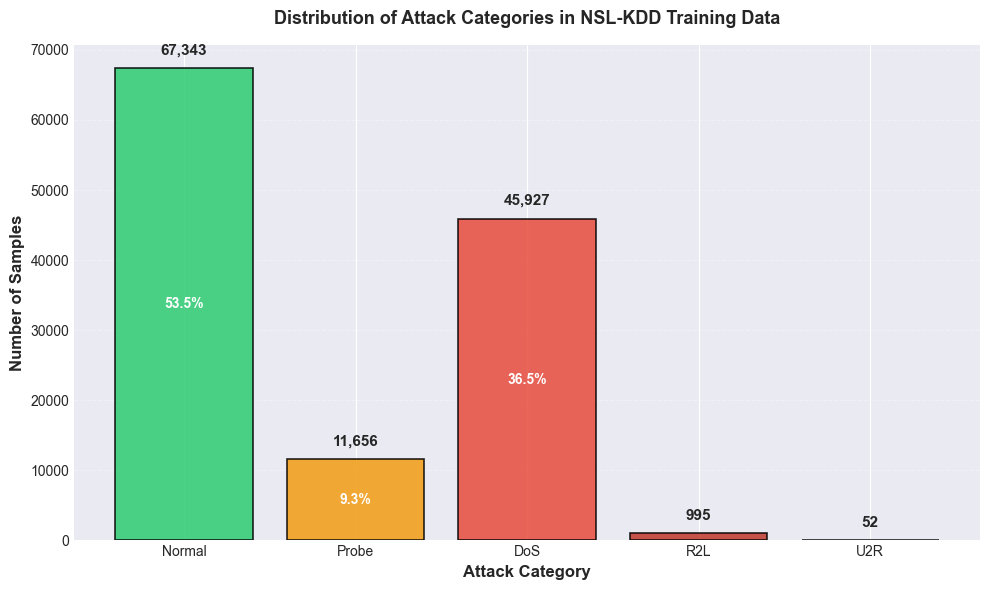

In [5]:
attack_mapping = {
    'normal': 'Normal',
    # DoS attacks
    'neptune': 'DoS', 'smurf': 'DoS', 'pod': 'DoS', 'teardrop': 'DoS',
    'land': 'DoS', 'back': 'DoS',
    # Probe attacks  
    'satan': 'Probe', 'ipsweep': 'Probe', 'portsweep': 'Probe', 'nmap': 'Probe',
    'mscan': 'Probe', 'saint': 'Probe',
    # R2L attacks
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L',
    'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L',
    'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpguess': 'R2L', 'snmpgetattack': 'R2L',
    'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
    # U2R attacks
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'rootkit': 'U2R', 'perl': 'U2R',
    'sqlattack': 'U2R', 'xterm': 'U2R', 'ps': 'U2R'
}

# Map attack types to categories
train_data['attack_category'] = train_data['attack_type'].map(attack_mapping)

# Handle unmapped attacks
if train_data['attack_category'].isna().any():
    print("⚠️ Warning: Some attacks couldn't be mapped. Setting to 'Unknown'")
    train_data['attack_category'].fillna('Unknown', inplace=True)

# Get category counts and order them
category_order = ['Normal', 'Probe', 'DoS', 'R2L', 'U2R']
category_counts = train_data['attack_category'].value_counts().reindex(category_order)

# Colors (green for normal, increasing reds for attacks)
colors = ['#2ecc71', '#f39c12', '#e74c3c', '#c0392b', '#8b0000']

# Create figure
plt.figure(figsize=(10, 6))

# Create bars
bars = plt.bar(category_order, category_counts.values, 
               color=colors, edgecolor='black', linewidth=1.2, alpha=0.85)

# Add count labels above bars
for i, count in enumerate(category_counts.values):
    plt.text(i, count + 1500, f'{count:,}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add percentage inside bars (only for tall bars)
    percentage = (count / len(train_data)) * 100
    if count > 3000:  # Only show if bar is tall enough
        plt.text(i, count/2, f'{percentage:.1f}%', 
                 ha='center', va='center', 
                 fontsize=10, color='white', fontweight='bold')

# Labels and title
plt.xlabel('Attack Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Distribution of Attack Categories in NSL-KDD Training Data', 
          fontsize=13, fontweight='bold', pad=15)

# Grid
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

---
### Conclusion:

The visualization reveals a **severe class imbalance problem** in the NSL-KDD dataset. Normal traffic dominates with over 67,000 samples (53%), while DoS attacks are the second most common at around 45,000 samples (36%). The concerning part is the rare attack types:

- **Probe attacks**: ~11,000 samples (9%) - Moderate representation, should be detectable
- **R2L attacks**: ~1,000 samples (0.8%) - Very rare, will be challenging to detect
- **U2R attacks**: ~52 samples (0.04%) - Extremely rare, only 52 examples!

#### What this means for my model:

If I train a model without addressing this imbalance, it could achieve 90% accuracy just by predicting "normal" or "DoS" for everything and completely ignoring the rare U2R and R2L attacks. But in cybersecurity, **missing a U2R privilege escalation attack is catastrophic** - that's someone getting root access to the system!

#### My strategy moving forward:

1. **Use SMOTE** in Iteration 2 to create synthetic samples of R2L and U2R attacks
2. **Set class weights** in my models to penalize misclassifying rare attacks more heavily
3. **Evaluate per-attack-type metrics** - overall accuracy will be misleading, I need F1-scores for each attack type separately
4. **Prioritize recall for rare attacks** - I'd rather have false positives than miss a U2R attack

This distribution also validates why NSL-KDD is realistic - in real networks, privilege escalation attacks ARE extremely rare compared to simple DoS floods. My model needs to handle this real-world imbalance effectively.